In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('train.csv')

At a glance:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


Виды преступлений:

In [10]:
df.DayOfWeek.value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

Посмотрим, что это за такие многочисленные и непонятные **OTHER OFFENSES** и **NON-CRIMINAL**:

In [12]:
#По большей части нарушения связанные с вождением:
df[(df.Category=='OTHER OFFENSES')&(df.DayOfWeek=='Monday')].Descript.value_counts()[:15]

DRIVERS LICENSE, SUSPENDED OR REVOKED             3731
TRAFFIC VIOLATION                                 2298
RESISTING ARREST                                  1207
PROBATION VIOLATION                               1143
MISCELLANEOUS INVESTIGATION                       1126
LOST/STOLEN LICENSE PLATE                          965
VIOLATION OF RESTRAINING ORDER                     867
TRAFFIC VIOLATION ARREST                           729
PAROLE VIOLATION                                   682
CONSPIRACY                                         498
OBSCENE PHONE CALLS(S)                             387
FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY     359
HARASSING PHONE CALLS                              326
POSSESSION OF BURGLARY TOOLS                       298
VIOLATION OF MUNICIPAL CODE                        261
Name: Descript, dtype: int64

In [94]:
#В основном потерянная/найденная собственность + неадекватные люди(? лол)
df[df.Category=='NON-CRIMINAL'].Descript.value_counts()[:15]

LOST PROPERTY                               31729
AIDED CASE, MENTAL DISTURBED                21497
FOUND PROPERTY                              12146
AIDED CASE                                   5419
DEATH REPORT, CAUSE UNKNOWN                  4207
CASE CLOSURE                                 2259
STAY AWAY OR COURT ORDER, NON-DV RELATED     1653
AIDED CASE, DOG BITE                         1336
CIVIL SIDEWALKS, CITATION                    1217
PROPERTY FOR IDENTIFICATION                  1200
AIDED CASE, INJURED PERSON                   1060
DEATH REPORT, NATURAL CAUSES                 1011
CIVIL SIDEWALKS, WARNING                      928
COURTESY REPORT                               874
FIRE REPORT                                   795
Name: Descript, dtype: int64

Посмотрим на распределение 3-х самых частых видов преступлений по районам и дням недели:

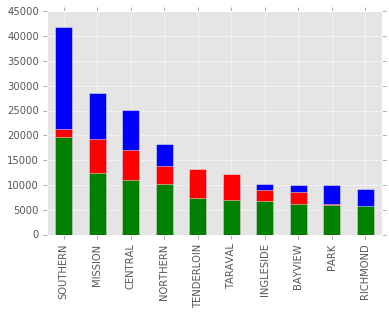

In [122]:
df[df.Category=='LARCENY/THEFT'].PdDistrict.value_counts().plot(kind='bar')
df[df.Category=='OTHER OFFENSES'].PdDistrict.value_counts().plot(kind='bar',color='red')
df[df.Category=='NON-CRIMINAL'].PdDistrict.value_counts().plot(kind='bar',color='green')
#Сорян, задолбался пытаться построить так, чтобы столбики были рядом :(

Сделаем то же для дней недели:

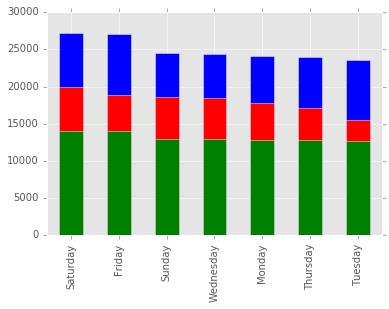

In [123]:
df[df.Category=='LARCENY/THEFT'].DayOfWeek.value_counts().plot(kind='bar')
df[df.Category=='OTHER OFFENSES'].DayOfWeek.value_counts().plot(kind='bar',color='red')
df[df.Category=='NON-CRIMINAL'].DayOfWeek.value_counts().plot(kind='bar',color='green')

Mildly Interesting: не ходите, дети, на *800 Block of BRYANT ST* гулять:

In [124]:
df.Address.value_counts()[:10]

800 Block of BRYANT ST      26533
800 Block of MARKET ST       6581
2000 Block of MISSION ST     5097
1000 Block of POTRERO AV     4063
900 Block of MARKET ST       3251
0 Block of TURK ST           3228
0 Block of 6TH ST            2884
300 Block of ELLIS ST        2703
400 Block of ELLIS ST        2590
16TH ST / MISSION ST         2504
Name: Address, dtype: int64

Повеселились и хватит.
Посмотрим теперь, насколько важны каждая из базовых фич, для чего используем возможности RandomForest.
Но перед этим поле даты разобьем на год, месяц и час + закодируем данные цифрами (иначе RandomForest не заработает):

In [137]:
le = LabelEncoder()
df['DayOfWeek'] = le.fit_transform(df.DayOfWeek)
df['PdDistrict'] = le.fit_transform(df.PdDistrict)
df['Address'] = le.fit_transform(df.Address)

df['Dates'] = pd.to_datetime(df.Dates, yearfirst=True)
df['Year'] = df.Dates.dt.year
df['Month'] = df.Dates.dt.month
df['Hour'] = df.Dates.dt.hour

Ок, время RF:

In [144]:
features = ['DayOfWeek', 'PdDistrict','X','Y','Address', 'Year', 'Month', 'Hour']
clf = RandomForestClassifier(n_estimators=10,random_state=42) 
#спойлер: на большем числе деревьев можно опухнуть считать, а важности фич отличаются незначительно
clf.fit(df[features], df.Category)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [143]:
zip(features,clf.feature_importances_)

[('DayOfWeek', 0.111478005770376),
 ('PdDistrict', 0.017239667013852881),
 ('X', 0.14891031143423883),
 ('Y', 0.15404873975333627),
 ('Address', 0.14053521924782411),
 ('Year', 0.10994748884512824),
 ('Month', 0.16288060110506705),
 ('Hour', 0.15495996683017663)]

К размышлению: PdDistrict совсем ничтожное влияние оказывает, хотя на графиках выше видно, что частота разных типов преступлений меняется в зависимости от района. WHYYY? Потому что это учитывается в X и Y? Если так, то почему у Address все еще значительный вес?

Ну и т.к. у месяца оказался самый большой вес, посмотрим для 3 самых частых типов преступлений распределение по месяцам:

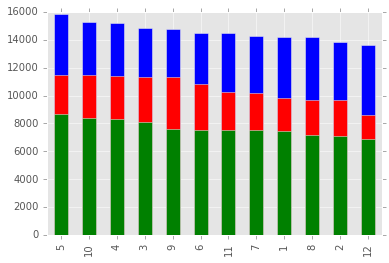

In [146]:
df[df.Category=='LARCENY/THEFT'].Month.value_counts().plot(kind='bar')
df[df.Category=='OTHER OFFENSES'].Month.value_counts().plot(kind='bar',color='red')
df[df.Category=='NON-CRIMINAL'].Month.value_counts().plot(kind='bar',color='green')

Mildly Interesting: 3 из 4 топовых месяца - это март, апрель, май - "весеннее обострение" confirmed :)
Ну и сделаем то же для Hour, напоследок:

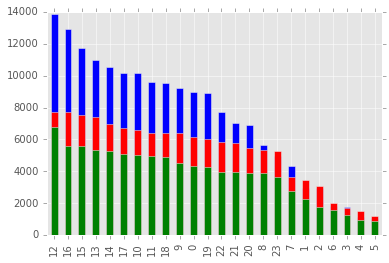

In [147]:
df[df.Category=='LARCENY/THEFT'].Hour.value_counts().plot(kind='bar')
df[df.Category=='OTHER OFFENSES'].Hour.value_counts().plot(kind='bar',color='red')
df[df.Category=='NON-CRIMINAL'].Hour.value_counts().plot(kind='bar',color='green')